In [1]:
!conda install pip -y
!pip install -U sentence-transformers
!pip install tf-keras

Channels:
 - defaults
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import re
from collections import defaultdict, Counter
import pandas as pd

## Install PDF Support (for PyMuPDF)

Required for extracting resume text from uploaded PDF files.


In [4]:
# Uncomment if running in a fresh environment
!pip install pymupdf

## Load the Datasets

In [6]:
queries_df = pd.read_csv('Resume.csv')  # Resumes as queries
documents_df = pd.read_csv('job_title_des.csv')  # Jobs as documents

print("Resume dataset columns:", queries_df.columns.tolist())
print("Job dataset columns:", documents_df.columns.tolist())

Resume dataset columns: ['ID', 'Resume_str', 'Resume_html', 'Category']
Job dataset columns: ['Document ID', 'Job Title', 'Job Description']


## Filter Resumes for Tech-Related Roles

In [8]:
queries_df['Category'] = queries_df['Category'].str.upper().str.strip()
target_categories = ['INFORMATION-TECHNOLOGY']  
filtered_queries = queries_df[queries_df['Category'].isin(target_categories)].copy()

## Basic Text Preprocessing

- Convert all text to lowercase for consistency.
- Strip leading and trailing whitespace.
- Apply these cleaning steps to relevant text columns (e.g., job descriptions, resume text).


In [10]:
def clean_text(text):
    if isinstance(text, str):
        return text.lower().strip()
    return ""

documents_df['cleaned_description'] = documents_df['Job Description'].apply(clean_text)
filtered_queries['cleaned_text'] = filtered_queries['Resume_str'].apply(clean_text)

## PDF Resume Text Extraction and Preprocessing

This section defines a helper function to extract text from a PDF resume and clean it using the same preprocessing as the existing resumes.

In [12]:
import fitz  # PyMuPDF
def extract_and_clean_pdf_resume(pdf_path):
    """Extract and clean text from a PDF resume using PyMuPDF."""
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return clean_text(text)  


In [13]:
# Preview the processed DataFrames to confirm changes
print("Resumes:")
print(filtered_queries[['ID']].head())
print(filtered_queries[['cleaned_text']].head())
print(filtered_queries[['Category']].head())

print("\nDocs:")
print(documents_df[['Job Title', 'cleaned_description']].head())

Resumes:
           ID
217  36856210
218  21780877
219  33241454
220  25990239
221  16899268
                                          cleaned_text
217  information technology         summary     ded...
218  information technology specialist\tgs11       ...
219  information technology supervisor       summar...
220  information technology instructor       summar...
221  information technology manager/analyst        ...
                   Category
217  INFORMATION-TECHNOLOGY
218  INFORMATION-TECHNOLOGY
219  INFORMATION-TECHNOLOGY
220  INFORMATION-TECHNOLOGY
221  INFORMATION-TECHNOLOGY

Docs:
              Job Title                                cleaned_description
0     Flutter Developer  we are looking for hire experts flutter develo...
1      Django Developer  python/django (developer/lead) - job code(pdj ...
2      Machine Learning  data scientist (contractor)\n\nbangalore, in\n...
3         iOS Developer  job description:\n\nstrong framework outside o...
4  Full Stack Developer  jo

## Building the Inverted Index

1. **Load Stopwords**  
   Load a predefined list of stopwords to exclude common, non-informative words from the index.

2. **Define Tokenizer**  
   Create a tokenizer function to split text into meaningful tokens.

3. **Build Inverted Index from Filtered Resumes**  
   Iterate through the filtered resumes and populate the inverted index, mapping each token to the list of document IDs in which it appears.


In [15]:
# load stopwords
with open("stopwords_en.txt", "r", encoding="utf-8") as f:
    stopwords = set(word.strip().lower() for word in f if len(word.strip()) > 1)

# define tokenizer
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()
    return [t for t in tokens if len(t) > 1 and t not in stopwords and not t.isdigit()]

In [16]:
inverted_index = {}

for _, row in documents_df.iterrows():
    doc_id = row['Document ID']
    content = row['cleaned_description']

    token_counts = defaultdict(int)
    for token in tokenize(content):
        token_counts[token] += 1

    for token, count in token_counts.items():
        if token not in inverted_index:
            inverted_index[token] = {
                'total_freq': 0,
                'doc_freq': 0,
                'postings': []
            }
        inverted_index[token]['total_freq'] += count
        inverted_index[token]['doc_freq'] += 1
        inverted_index[token]['postings'].append((doc_id, count))


In [17]:
# Display a preview of the inverted index (first 15 terms by alphabetical order)
index_table = []
for token in sorted(inverted_index):
    entry = inverted_index[token]
    index_table.append({
        'Index Term': token,
        'Total Frequency': entry['total_freq'],
        'Document Frequency': entry['doc_freq'],
        'Postings (Job ID, Count)': entry['postings']
    })

df = pd.DataFrame(index_table)

df = df.sort_values(by='Total Frequency', ascending=False)

pd.set_option('display.max_colwidth', None)
print("=== Inverted Index Preview (Top 15 Frequent Terms) ===")
print(df.head(15))

=== Inverted Index Preview (Top 15 Frequent Terms) ===
          Index Term  Total Frequency  Document Frequency  \
6677      experience             9569                2115   
19614           work             4753                1743   
5270     development             4088                1570   
10184      knowledge             3174                1434   
17754           team             3030                1257   
16670       software             2868                1164   
5159          design             2821                1269   
19885          years             2688                1417   
4776            data             2638                 917   
16528         skills             2585                1291   
9871             job             2578                1591   
13838      preferred             2459                 993   
15167       required             2143                 987   
18643  understanding             2080                 994   
19637        working          

In [18]:
all_tokens = []
for text in documents_df['cleaned_description']:
    all_tokens.extend(tokenize(text))

print("\n=== Top 20 Most Frequent Tokens in Job Descriptions (Excluding Stopwords) ===")
print(Counter(all_tokens).most_common(20))


=== Top 20 Most Frequent Tokens in Job Descriptions (Excluding Stopwords) ===
[('experience', 9569), ('work', 4753), ('development', 4088), ('knowledge', 3174), ('team', 3030), ('software', 2868), ('design', 2821), ('years', 2688), ('data', 2638), ('skills', 2585), ('job', 2578), ('preferred', 2459), ('required', 2143), ('understanding', 2080), ('working', 1981), ('application', 1911), ('year', 1895), ('strong', 1849), ('web', 1810), ('code', 1725)]


In [19]:
import math

def compute_tfidf_scores(query, inverted_index, total_docs, top_k=10):
    query_tokens = tokenize(query)
    
    query_tf = defaultdict(int) # count query token frequencies
    for token in query_tokens:
        query_tf[token] += 1

    idf = {}
    for token in query_tf:
        if token in inverted_index:
            df = inverted_index[token]['doc_freq']
            idf[token] = math.log(total_docs / df)  # compute IDF for each token in query
        else:
            idf[token] = 0  # if unseen token then ignore it


    # ompute TF-IDF for the query and its norm
    query_tfidf = {}
    for token in query_tf:
        query_tfidf[token] = query_tf[token] * idf[token]

    query_norm = math.sqrt(sum(val**2 for val in query_tfidf.values()))  # ||Q||

    scores = defaultdict(float)    # dot product numerator
    doc_norms = defaultdict(float) # track ||D|| per doc

    for token, q_tfidf in query_tfidf.items():
        if token not in inverted_index:
            continue
        postings = inverted_index[token]['postings']
        idf_val = idf[token]

        for doc_id, tf in postings:
            d_tfidf = tf * idf_val
            scores[doc_id] += q_tfidf * d_tfidf    # dot product Q·D
            doc_norms[doc_id] += d_tfidf ** 2      # sum squares for ||D||

    # finalize cosine similarity
    cosine_scores = {}
    for doc_id in scores:
        doc_norm = math.sqrt(doc_norms[doc_id])
        if doc_norm == 0 or query_norm == 0:
            cosine_scores[doc_id] = 0
        else:
            cosine_scores[doc_id] = scores[doc_id] / (query_norm * doc_norm)

    ranked = sorted(cosine_scores.items(), key=lambda x: x[1], reverse=True)
    return ranked[:top_k]

## TF-IDF: Match Jobs to Uploaded PDF Resume

This function uses the existing TF-IDF scoring system to retrieve the top-k job matches for a user-uploaded PDF resume.

In [21]:
def match_pdf_resume_tfidf(pdf_path, inverted_index, job_df, total_docs, top_k=10):
    cleaned_resume = extract_and_clean_pdf_resume(pdf_path)
    
    results = compute_tfidf_scores(
        query=cleaned_resume,
        inverted_index=inverted_index,
        total_docs=total_docs,
        top_k=top_k
    )
    
    print("=== TF-IDF Top Job Matches ===")
    for rank, (doc_id, score) in enumerate(results, 1):
        title = job_df.loc[doc_id, 'Job Title']
        print(f"{rank}. {title} (Score: {score:.4f})")
    
    return results

In [22]:
def match_job_to_resumes_tfidf(job_index, job_text, job_title, resumes_df, top_k=10):
    """
    Match a job description to top resumes using TF-IDF.
    """
    total_docs = len(resumes_df)
    
    # Build inverted index over resumes
    resume_inverted_index = {}
    for _, row in resumes_df.iterrows():
        doc_id = row['ID']
        content = row['cleaned_text']
        token_counts = defaultdict(int)
        for token in tokenize(content):
            token_counts[token] += 1
        for token, count in token_counts.items():
            if token not in resume_inverted_index:
                resume_inverted_index[token] = {
                    'total_freq': 0,
                    'doc_freq': 0,
                    'postings': []
                }
            resume_inverted_index[token]['total_freq'] += count
            resume_inverted_index[token]['doc_freq'] += 1
            resume_inverted_index[token]['postings'].append((doc_id, count))

    # Compute similarity
    results = compute_tfidf_scores(job_text, resume_inverted_index, total_docs, top_k=top_k)

    print(f"\n=== TF-IDF Top Resume Matches for Job #{job_index}: {job_title} ===")
    for rank, (doc_id, score) in enumerate(results, 1):
        print(f"{rank}. Resume ID: {doc_id} (Score: {score:.4f})")


In [23]:
# Example: Pick first job description to test TF-IDF-based reverse matching
sample_job = documents_df.iloc[0]
job_index = sample_job['Document ID']
job_text = sample_job['cleaned_description']
job_title = sample_job['Job Title']

# Match this job to resumes
match_job_to_resumes_tfidf(
    job_index=job_index,
    job_text=job_text,
    job_title=job_title,
    resumes_df=filtered_queries,
    top_k=10
)


=== TF-IDF Top Resume Matches for Job #0: Flutter Developer ===
1. Resume ID: 27058381 (Score: 0.4165)
2. Resume ID: 32959732 (Score: 0.3144)
3. Resume ID: 90867631 (Score: 0.3090)
4. Resume ID: 27372171 (Score: 0.2782)
5. Resume ID: 64017585 (Score: 0.2771)
6. Resume ID: 22450718 (Score: 0.2712)
7. Resume ID: 10553553 (Score: 0.2710)
8. Resume ID: 18159866 (Score: 0.2699)
9. Resume ID: 51363762 (Score: 0.2637)
10. Resume ID: 10265057 (Score: 0.2614)


In [24]:
# Pick a resume to test
resume_row = filtered_queries.iloc[0]
resume_id = resume_row["ID"]
query = resume_row["cleaned_text"]
total_docs = len(documents_df)

results = compute_tfidf_scores(query, inverted_index, total_docs, top_k=10)

print(f"=== Top Job Matches for Resume ID: {resume_id} ===")
for i, (doc_id, score) in enumerate(results, 1):
    job_title = documents_df[documents_df['Document ID'] == doc_id]['Job Title'].values[0]
    print(f"{i}. {job_title} (Score: {score:.4f})")


=== Top Job Matches for Resume ID: 36856210 ===
1. Database Administrator (Score: 0.4437)
2. Database Administrator (Score: 0.3455)
3. Database Administrator (Score: 0.3129)
4. Machine Learning (Score: 0.3092)
5. DevOps Engineer (Score: 0.2904)
6. Database Administrator (Score: 0.2877)
7. Network Administrator (Score: 0.2868)
8. Database Administrator (Score: 0.2841)
9. Network Administrator (Score: 0.2839)
10. DevOps Engineer (Score: 0.2809)


## Save TF-IDF Job Matches for All Resumes

This function loops through each resume in the dataset, retrieves the top matching job descriptions using TF-IDF cosine similarity, and saves the results to a CSV file.

### Output Columns:
- `Resume_ID`
- `Rank`
- `Matched_Job_ID`
- `Job_Title`
- `TFIDF_Score`

### Usage Example:
```python
save_tfidf_results_for_all_resumes(filtered_queries, documents_df, inverted_index)


In [26]:
def save_tfidf_results_for_all_resumes(filtered_queries, documents_df, inverted_index, output_path="tfidf_resume_to_jobs.csv", top_k=10):
    total_docs = len(documents_df)
    output_rows = []

    for i, row in filtered_queries.iterrows():
        resume_id = row.get("ID", i)
        resume_text = row['cleaned_text']

        results = compute_tfidf_scores(resume_text, inverted_index, total_docs, top_k=top_k)

        for rank, (job_id, score) in enumerate(results, start=1):
            job_row = documents_df[documents_df['Document ID'] == job_id]
            job_title = job_row['Job Title'].values[0] if not job_row.empty else "Unknown"

            output_rows.append({
                "Resume_ID": resume_id,
                "Rank": rank,
                "Matched_Job_ID": job_id,
                "Job_Title": job_title,
                "TFIDF_Score": score
            })

    tfidf_output_df = pd.DataFrame(output_rows)
    tfidf_output_df.to_csv(output_path, index=False)
    print(f"TF-IDF matches saved to '{output_path}'")

In [27]:
save_tfidf_results_for_all_resumes(filtered_queries, documents_df, inverted_index) 

TF-IDF matches saved to 'tfidf_resume_to_jobs.csv'


## Switching to Semantic Retrieval (LLM-based)

Up to this point, we used traditional TF-IDF with cosine similarity to match resumes to job descriptions.

In this section, we transition to a **semantic retrieval approach** using a pre-trained transformer model (`all-MiniLM-L6-v2`). Instead of relying on exact token overlap, this method captures **semantic meaning** to compute similarity between resumes and job descriptions in embedding space.

### Key Difference:
- **TF-IDF**: Lexical overlap-based
- **LLM Embeddings**: Context-aware, meaning-based

We now treat **resumes as queries** and **jobs as documents**, and use cosine similarity over embeddings to find top-matching jobs.


In [29]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import torch

# Load pre-trained embedding model
llm_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode job descriptions (documents)
job_ids = documents_df['Document ID'].tolist()
job_titles = documents_df['Job Title'].tolist()
job_texts = documents_df['cleaned_description'].tolist()
job_embeddings = llm_model.encode(job_texts, convert_to_tensor=True, normalize_embeddings=True)

# Encode resumes (queries)
resume_ids = filtered_queries['ID'].tolist() if 'ID' in filtered_queries.columns else list(range(len(filtered_queries)))
resume_texts = filtered_queries['cleaned_text'].tolist()
resume_embeddings = llm_model.encode(resume_texts, convert_to_tensor=True, normalize_embeddings=True)

## LLM: Match Jobs to Uploaded PDF Resume

This function uses semantic similarity (SentenceTransformers) to match a user-uploaded PDF resume to the most relevant job descriptions.

## Save LLM-Based Job Matches for All Resumes

This function uses semantic embeddings from a pre-trained language model (e.g., SentenceTransformer) to find top-matching job descriptions for each resume. It computes cosine similarity between each resume and all job descriptions, then saves the top results to a CSV.

### Output Columns:
- `Resume_ID`
- `Rank`
- `Matched_Job_ID`
- `Job_Title`
- `LLM_Score`

### Usage Example:
```python
save_llm_results_for_all_resumes(filtered_queries, documents_df, llm_model, job_embeddings)

In [32]:
def match_pdf_resume_llm(pdf_path, job_df, llm_model, job_embeddings, top_k=10):
    cleaned_resume = extract_and_clean_pdf_resume(pdf_path)

    resume_embedding = llm_model.encode(cleaned_resume, convert_to_tensor=True, normalize_embeddings=True)

    from sentence_transformers import util
    cosine_scores = util.cos_sim(resume_embedding, job_embeddings)[0]
    top_results = torch.topk(cosine_scores, k=top_k)

    print("=== LLM Top Job Matches ===")
    for rank, (score, idx) in enumerate(zip(top_results.values, top_results.indices), start=1):
        job_idx = idx.item()  # Convert tensor to int
        title = job_df.iloc[job_idx]['Job Title']
        print(f"{rank}. {title} (Score: {score.item():.4f})")
        
    return top_results

In [33]:
def save_llm_results_for_all_resumes(filtered_queries, documents_df, llm_model, job_embeddings, output_path="llm_resume_to_jobs.csv", top_k=10):
    from sentence_transformers import util
    import torch
    import pandas as pd

    resume_ids = filtered_queries['ID'].tolist() if 'ID' in filtered_queries.columns else list(range(len(filtered_queries)))
    resume_texts = filtered_queries['cleaned_text'].tolist()
    
    output_rows = []

    for i, resume_text in enumerate(resume_texts):
        resume_id = resume_ids[i]

        # Encode the resume as a query
        resume_embedding = llm_model.encode(resume_text, convert_to_tensor=True, normalize_embeddings=True)

        # Compute cosine similarity to all job embeddings
        cosine_scores = util.cos_sim(resume_embedding, job_embeddings)[0]
        top_results = torch.topk(cosine_scores, k=top_k)

        for rank, (score, idx) in enumerate(zip(top_results.values, top_results.indices), start=1):
            idx = int(idx)  # convert from tensor to int
            job_id = documents_df.iloc[idx]['Document ID']
            job_title = documents_df.iloc[idx]['Job Title']

            output_rows.append({
                'Resume_ID': resume_id,
                'Rank': rank,
                'Matched_Job_ID': job_id,
                'Job_Title': job_title,
                'LLM_Score': round(score.item(), 4)
            })

    llm_output_df = pd.DataFrame(output_rows)
    llm_output_df.to_csv(output_path, index=False)
    print(f"LLM-based matches saved to '{output_path}'")

In [34]:
def match_job_to_resumes_llm(job_index, job_text, job_title, resume_df, llm_model, resume_embeddings, top_k=10):
    """
    Given a job description, find top-matching resumes using LLM embeddings.
    """
    from sentence_transformers import util
    import torch

    # Encode the job description
    job_embedding = llm_model.encode(job_text, convert_to_tensor=True, normalize_embeddings=True)

    # Compute cosine similarity between job and all resume embeddings
    cosine_scores = util.cos_sim(job_embedding, resume_embeddings)[0]
    top_results = torch.topk(cosine_scores, k=top_k)

    print(f"\n=== LLM Top Resume Matches for Job #{job_index}: {job_title} ===")
    for rank, (score, idx) in enumerate(zip(top_results.values, top_results.indices), start=1):
        resume_id = resume_df.iloc[idx.item()]["ID"]
        print(f"{rank}. Resume ID: {resume_id} (Score: {score.item():.4f})")


In [35]:
# Test LLM-based matching from job to resumes
sample_job = documents_df.iloc[0]
job_index = sample_job['Document ID']
job_text = sample_job['cleaned_description']
job_title = sample_job['Job Title']

match_job_to_resumes_llm(
    job_index=job_index,
    job_text=job_text,
    job_title=job_title,
    resume_df=filtered_queries,
    llm_model=llm_model,
    resume_embeddings=resume_embeddings,
    top_k=10
)


=== LLM Top Resume Matches for Job #0: Flutter Developer ===
1. Resume ID: 39413067 (Score: 0.5122)
2. Resume ID: 37242217 (Score: 0.4407)
3. Resume ID: 11580408 (Score: 0.3829)
4. Resume ID: 17641670 (Score: 0.3729)
5. Resume ID: 26480367 (Score: 0.3721)
6. Resume ID: 36434348 (Score: 0.3617)
7. Resume ID: 15651486 (Score: 0.3609)
8. Resume ID: 25207620 (Score: 0.3573)
9. Resume ID: 22450718 (Score: 0.3555)
10. Resume ID: 37764298 (Score: 0.3544)


In [36]:
# Test LLM matching from a resume to job descriptions
resume_row = filtered_queries.iloc[0]
resume_id = resume_row["ID"]
resume_text = resume_row["cleaned_text"]

# Encode the resume
resume_embedding = llm_model.encode(resume_text, convert_to_tensor=True, normalize_embeddings=True)

# Compute cosine similarity
cosine_scores = util.cos_sim(resume_embedding, job_embeddings)[0]
top_results = torch.topk(cosine_scores, k=10)

print(f"=== LLM Top Job Matches for Resume ID: {resume_id} ===")
for rank, (score, idx) in enumerate(zip(top_results.values, top_results.indices), start=1):
    job_title = documents_df.iloc[idx.item()]["Job Title"]
    print(f"{rank}. {job_title} (Score: {score.item():.4f})")

=== LLM Top Job Matches for Resume ID: 36856210 ===
1. Network Administrator (Score: 0.6007)
2. Network Administrator (Score: 0.5993)
3. Software Engineer (Score: 0.5954)
4. Network Administrator (Score: 0.5944)
5. Network Administrator (Score: 0.5876)
6. Network Administrator (Score: 0.5853)
7. Network Administrator (Score: 0.5826)
8. Database Administrator (Score: 0.5802)
9. Network Administrator (Score: 0.5719)
10. Database Administrator (Score: 0.5686)


In [37]:
save_llm_results_for_all_resumes(filtered_queries, documents_df, llm_model, job_embeddings)

LLM-based matches saved to 'llm_resume_to_jobs.csv'


## Precision, Recall, and F1 Evaluation

In this section, we evaluate the effectiveness of our retrieval system using standard IR metrics:
- **Precision@k**: What proportion of the top-k results are relevant?
- **Recall@k**: What proportion of all relevant results were returned in the top-k?
- **F1@k**: Harmonic mean of Precision and Recall — balances both.

We evaluate each resume (Sue, RDH, Shang) against a manually selected set of job descriptions that are deemed relevant. Both **TF-IDF** and **LLM**-based models are used for comparison.


In [39]:
# Precision, Recall, F1 @ k
def precision_at_k(retrieved, relevant, k):
    retrieved_k = retrieved[:k]
    relevant_set = set(relevant)
    hits = sum(1 for item in retrieved_k if item in relevant_set)
    return hits / k

def recall_at_k(retrieved, relevant, k):
    retrieved_k = retrieved[:k]
    relevant_set = set(relevant)
    hits = sum(1 for item in retrieved_k if item in relevant_set)
    return hits / len(relevant) if relevant else 0

def f1_at_k(retrieved, relevant, k):
    p = precision_at_k(retrieved, relevant, k)
    r = recall_at_k(retrieved, relevant, k)
    return (2 * p * r) / (p + r) if (p + r) else 0


In [40]:
# Define relevant jobs for each resume
sue_relevant = documents_df[documents_df['Job Title'] == 'Machine Learning']['Document ID'].values.tolist()
RDH_relevant = documents_df[documents_df['Job Title'].isin(['DevOps Engineer','Software Engineer'])]['Document ID'].values.tolist()
shang_relevant = documents_df[documents_df['Job Title'].isin(['DevOps Engineer','Software Engineer'])]['Document ID'].values.tolist()

### Evaluation: Sue Yang Resume

Sue's resume is assessed against job titles that are most relevant to her background (e.g., "Machine Learning").


In [42]:
Sue_tfidf_results = match_pdf_resume_tfidf("Sue Yang Resume.pdf", inverted_index, documents_df, total_docs=len(documents_df))
Sue_llm_results = match_pdf_resume_llm("Sue Yang Resume.pdf", documents_df, llm_model, job_embeddings)

Sue_tfidf_retrieved = [item[0] for item in Sue_tfidf_results]
Sue_llm_retrieved = Sue_llm_results.indices.tolist()

print("=== Sue Yang Resume Metrics @10 ===")
print("TF-IDF - P:", precision_at_k(Sue_tfidf_retrieved, sue_relevant, 10),
      "R:", recall_at_k(Sue_tfidf_retrieved, sue_relevant, 10),
      "F1:", f1_at_k(Sue_tfidf_retrieved, sue_relevant, 10))
print("LLM     - P:", precision_at_k(Sue_llm_retrieved, sue_relevant, 10),
      "R:", recall_at_k(Sue_llm_retrieved, sue_relevant, 10),
      "F1:", f1_at_k(Sue_llm_retrieved, sue_relevant, 10))

=== TF-IDF Top Job Matches ===
1. Django Developer (Score: 0.3518)
2. Machine Learning (Score: 0.3420)
3. PHP Developer (Score: 0.3250)
4. Java Developer (Score: 0.3189)
5. Machine Learning (Score: 0.3049)
6. Java Developer (Score: 0.2996)
7. Machine Learning (Score: 0.2883)
8. Machine Learning (Score: 0.2837)
9. JavaScript Developer (Score: 0.2836)
10. Machine Learning (Score: 0.2836)
=== LLM Top Job Matches ===
1. Machine Learning (Score: 0.6264)
2. Machine Learning (Score: 0.6155)
3. Machine Learning (Score: 0.6119)
4. Machine Learning (Score: 0.6063)
5. Machine Learning (Score: 0.5968)
6. Machine Learning (Score: 0.5879)
7. Machine Learning (Score: 0.5843)
8. Machine Learning (Score: 0.5826)
9. Machine Learning (Score: 0.5790)
10. Machine Learning (Score: 0.5784)
=== Sue Yang Resume Metrics @10 ===
TF-IDF - P: 0.5 R: 0.03289473684210526 F1: 0.061728395061728385
LLM     - P: 1.0 R: 0.06578947368421052 F1: 0.12345679012345677


###  Evaluation: RDH Resume

RDH's resume is matched against jobs like "DevOps Engineer" and "Software Engineer" based on his career in software infrastructure and MLOps.


In [44]:
RDH_tfidf_results = match_pdf_resume_tfidf("RDH Resume.pdf", inverted_index, documents_df, total_docs=len(documents_df))
RDH_llm_results = match_pdf_resume_llm("RDH Resume.pdf", documents_df, llm_model, job_embeddings)

RDH_tfidf_retrieved = [item[0] for item in RDH_tfidf_results]
RDH_llm_retrieved = RDH_llm_results.indices.tolist()

print("=== RDH Resume Metrics @10 ===")
print("TF-IDF - P:", precision_at_k(RDH_tfidf_retrieved, RDH_relevant, 10),
      "R:", recall_at_k(RDH_tfidf_retrieved, RDH_relevant, 10),
      "F1:", f1_at_k(RDH_tfidf_retrieved, RDH_relevant, 10))
print("LLM     - P:", precision_at_k(RDH_llm_retrieved, RDH_relevant, 10),
      "R:", recall_at_k(RDH_llm_retrieved, RDH_relevant, 10),
      "F1:", f1_at_k(RDH_llm_retrieved, RDH_relevant, 10))


=== TF-IDF Top Job Matches ===
1. Django Developer (Score: 0.4331)
2. Java Developer (Score: 0.3332)
3. Database Administrator (Score: 0.3291)
4. Full Stack Developer (Score: 0.3058)
5. JavaScript Developer (Score: 0.2922)
6. Database Administrator (Score: 0.2714)
7. DevOps Engineer (Score: 0.2492)
8. Database Administrator (Score: 0.2382)
9. Java Developer (Score: 0.2360)
10. Database Administrator (Score: 0.2330)
=== LLM Top Job Matches ===
1. JavaScript Developer (Score: 0.5260)
2. Software Engineer (Score: 0.5182)
3. DevOps Engineer (Score: 0.5160)
4. DevOps Engineer (Score: 0.5141)
5. DevOps Engineer (Score: 0.4810)
6. DevOps Engineer (Score: 0.4705)
7. DevOps Engineer (Score: 0.4688)
8. DevOps Engineer (Score: 0.4665)
9. Django Developer (Score: 0.4633)
10. DevOps Engineer (Score: 0.4632)
=== RDH Resume Metrics @10 ===
TF-IDF - P: 0.1 R: 0.0031746031746031746 F1: 0.006153846153846153
LLM     - P: 0.8 R: 0.025396825396825397 F1: 0.049230769230769224


###  Evaluation: Shang Resume

Shang's resume focuses on backend/DevOps roles, and is matched against similar job titles.


In [46]:
Shang_tfidf_results = match_pdf_resume_tfidf("Shang Andrews Resume 0.1.3.pdf", inverted_index, documents_df, total_docs=len(documents_df))
Shang_llm_results = match_pdf_resume_llm("Shang Andrews Resume 0.1.3.pdf", documents_df, llm_model, job_embeddings)

Shang_tfidf_retrieved = [item[0] for item in Shang_tfidf_results]
Shang_llm_retrieved = Shang_llm_results.indices.tolist()

print("=== Shang Resume Metrics @10 ===")
print("TF-IDF - P:", precision_at_k(Shang_tfidf_retrieved, shang_relevant, 10),
      "R:", recall_at_k(Shang_tfidf_retrieved, shang_relevant, 10),
      "F1:", f1_at_k(Shang_tfidf_retrieved, shang_relevant, 10))
print("LLM     - P:", precision_at_k(Shang_llm_retrieved, shang_relevant, 10),
      "R:", recall_at_k(Shang_llm_retrieved, shang_relevant, 10),
      "F1:", f1_at_k(Shang_llm_retrieved, shang_relevant, 10))


=== TF-IDF Top Job Matches ===
1. Database Administrator (Score: 0.3293)
2. DevOps Engineer (Score: 0.3187)
3. DevOps Engineer (Score: 0.3151)
4. DevOps Engineer (Score: 0.3137)
5. DevOps Engineer (Score: 0.3136)
6. DevOps Engineer (Score: 0.3077)
7. DevOps Engineer (Score: 0.3070)
8. DevOps Engineer (Score: 0.3058)
9. DevOps Engineer (Score: 0.3005)
10. DevOps Engineer (Score: 0.2996)
=== LLM Top Job Matches ===
1. DevOps Engineer (Score: 0.6507)
2. DevOps Engineer (Score: 0.6388)
3. DevOps Engineer (Score: 0.6346)
4. DevOps Engineer (Score: 0.6284)
5. DevOps Engineer (Score: 0.6180)
6. DevOps Engineer (Score: 0.6148)
7. DevOps Engineer (Score: 0.6140)
8. DevOps Engineer (Score: 0.6097)
9. DevOps Engineer (Score: 0.6082)
10. DevOps Engineer (Score: 0.6074)
=== Shang Resume Metrics @10 ===
TF-IDF - P: 0.9 R: 0.02857142857142857 F1: 0.05538461538461538
LLM     - P: 1.0 R: 0.031746031746031744 F1: 0.06153846153846154


## Example: Upload a PDF Resume and Match Against Job Descriptions

Use this section to test the matching functions with a specific PDF resume.


In [48]:
match_pdf_resume_tfidf("Shang Andrews Resume 0.1.3.pdf", inverted_index, documents_df, total_docs=len(documents_df))
print()
match_pdf_resume_llm("Shang Andrews Resume 0.1.3.pdf", documents_df, llm_model, job_embeddings)

=== TF-IDF Top Job Matches ===
1. Database Administrator (Score: 0.3293)
2. DevOps Engineer (Score: 0.3187)
3. DevOps Engineer (Score: 0.3151)
4. DevOps Engineer (Score: 0.3137)
5. DevOps Engineer (Score: 0.3136)
6. DevOps Engineer (Score: 0.3077)
7. DevOps Engineer (Score: 0.3070)
8. DevOps Engineer (Score: 0.3058)
9. DevOps Engineer (Score: 0.3005)
10. DevOps Engineer (Score: 0.2996)

=== LLM Top Job Matches ===
1. DevOps Engineer (Score: 0.6507)
2. DevOps Engineer (Score: 0.6388)
3. DevOps Engineer (Score: 0.6346)
4. DevOps Engineer (Score: 0.6284)
5. DevOps Engineer (Score: 0.6180)
6. DevOps Engineer (Score: 0.6148)
7. DevOps Engineer (Score: 0.6140)
8. DevOps Engineer (Score: 0.6097)
9. DevOps Engineer (Score: 0.6082)
10. DevOps Engineer (Score: 0.6074)


torch.return_types.topk(
values=tensor([0.6507, 0.6388, 0.6346, 0.6284, 0.6180, 0.6148, 0.6140, 0.6097, 0.6082,
        0.6074]),
indices=tensor([ 725,  345,  888,  994, 1444, 1405,  126,  880, 1109,  850]))

## Load and Compare Retrieval Results 

This section loads the CSVs produced by both retrieval methods — TF-IDF and LLM — where each **resume** is used to retrieve **top-matching jobs**.

### What We Compare:
- **Overlap in Top-*k* Jobs per Resume**
- **Agreement Percentage between TF-IDF and LLM**

This analysis helps us visualize how semantically different the retrievals are between traditional keyword-based and contextual embeddings.


In [50]:
# Load both results (resume-to-job matches)
tfidf_df = pd.read_csv("tfidf_resume_to_jobs.csv")
llm_df = pd.read_csv("llm_resume_to_jobs.csv")

tfidf_df['TFIDF_Score'] = pd.to_numeric(tfidf_df['TFIDF_Score'], errors='coerce')
llm_df['LLM_Score'] = pd.to_numeric(llm_df['LLM_Score'], errors='coerce')

# Prepare overlap comparison
overlap_summary = []
resume_ids = sorted(set(tfidf_df['Resume_ID']) & set(llm_df['Resume_ID']))

for resume_id in resume_ids:
    tfidf_subset = tfidf_df[tfidf_df['Resume_ID'] == resume_id]
    llm_subset = llm_df[llm_df['Resume_ID'] == resume_id]
    
    tfidf_jobs = set(tfidf_subset['Matched_Job_ID'].tolist())
    llm_jobs = set(llm_subset['Matched_Job_ID'].tolist())

    overlap = tfidf_jobs & llm_jobs
    overlap_count = len(overlap)

    overlap_summary.append({
        'Resume_ID': resume_id,
        'TFIDF Top-K': len(tfidf_jobs),
        'LLM Top-K': len(llm_jobs),
        'Overlap Count': overlap_count,
        'Overlap %': round(overlap_count / 10 * 100, 1)
    })

# Display as DataFrame
comparison_df = pd.DataFrame(overlap_summary)
print("=== TF-IDF vs LLM Retrieval Overlap Summary ===")
print(comparison_df.to_string(index=False))


=== TF-IDF vs LLM Retrieval Overlap Summary ===
 Resume_ID  TFIDF Top-K  LLM Top-K  Overlap Count  Overlap %
  10089434           10         10              2       20.0
  10247517           10         10              1       10.0
  10265057           10         10              0        0.0
  10553553           10         10              1       10.0
  10641230           10         10              0        0.0
  10839851           10         10              0        0.0
  10840430           10         10              1       10.0
  11580408           10         10              1       10.0
  11584809           10         10              2       20.0
  11957080           10         10              0        0.0
  12045067           10         10              1       10.0
  12334140           10         10              0        0.0
  12635195           10         10              0        0.0
  12763627           10         10              1       10.0
  13385306           10         10   

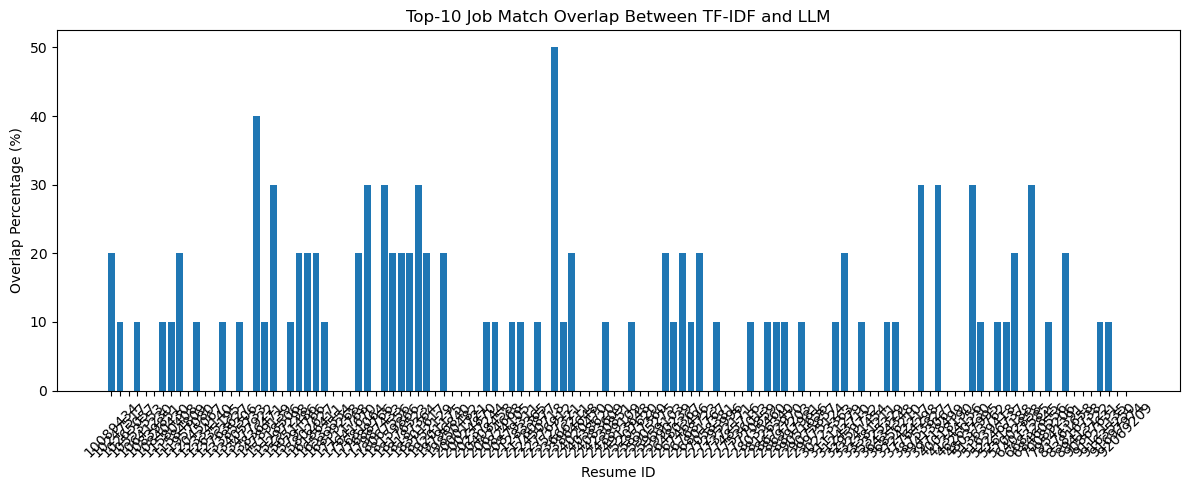

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(comparison_df['Resume_ID'].astype(str), comparison_df['Overlap %'])
plt.xlabel('Resume ID')
plt.ylabel('Overlap Percentage (%)')
plt.title('Top-10 Job Match Overlap Between TF-IDF and LLM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [52]:
def compute_retrieval_overlap_metrics(tfidf_path, llm_path, top_k=10):
    """
    Computes overall retrieval comparison metrics between TF-IDF and LLM-based methods.

    Returns a dictionary with average overlap percentage, average TF-IDF score, and average LLM score.
    """

    tfidf_df = pd.read_csv(tfidf_path)
    llm_df = pd.read_csv(llm_path)

    tfidf_df['TFIDF_Score'] = pd.to_numeric(tfidf_df['TFIDF_Score'], errors='coerce')
    llm_df['LLM_Score'] = pd.to_numeric(llm_df['LLM_Score'], errors='coerce')

    resume_ids = sorted(set(tfidf_df['Resume_ID']) & set(llm_df['Resume_ID']))
    results = []

    for resume_id in resume_ids:
        tfidf_jobs = set(tfidf_df[tfidf_df['Resume_ID'] == resume_id]['Matched_Job_ID'])
        llm_jobs = set(llm_df[llm_df['Resume_ID'] == resume_id]['Matched_Job_ID'])
        overlap = tfidf_jobs & llm_jobs

        results.append({
            'overlap_pct': len(overlap) / top_k * 100,
            'avg_tfidf': tfidf_df[tfidf_df['Resume_ID'] == resume_id]['TFIDF_Score'].mean(),
            'avg_llm': llm_df[llm_df['Resume_ID'] == resume_id]['LLM_Score'].mean()
        })

    # Aggregate metrics
    avg_overlap_pct = sum(r['overlap_pct'] for r in results) / len(results)
    avg_tfidf_score = sum(r['avg_tfidf'] for r in results) / len(results)
    avg_llm_score = sum(r['avg_llm'] for r in results) / len(results)

    return {
        'Average_Overlap_Percentage': round(avg_overlap_pct, 2),
        'Average_TFIDF_Score': round(avg_tfidf_score, 4),
        'Average_LLM_Score': round(avg_llm_score, 4)
    }


In [53]:
metrics = compute_retrieval_overlap_metrics(
    tfidf_path="tfidf_resume_to_jobs.csv",
    llm_path="llm_resume_to_jobs.csv"
)
print(metrics)


{'Average_Overlap_Percentage': 8.75, 'Average_TFIDF_Score': 0.3402, 'Average_LLM_Score': 0.5942}
